In [3]:
#Étape 1 – Division du jeu de données en train et validation

import os
import shutil
from sklearn.model_selection import train_test_split

def split_train_val(image_dir, val_dir, val_ratio=0.2):
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    images = os.listdir(image_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)
    for img in val_imgs:
        shutil.copy(os.path.join(image_dir, img), os.path.join(val_dir, img))

# Appliquer sur les deux classes
split_train_val('data/train/benign', 'data/val/benign')
split_train_val('data/train/malignant', 'data/val/malignant')


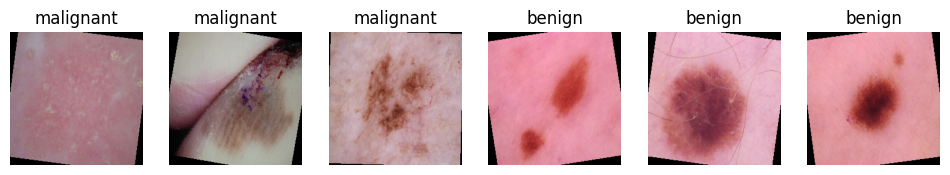

In [4]:
# Étape 2 – Chargement des données avec transformations et visualisation

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transform)
val_dataset = datasets.ImageFolder('data/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder('data/test', transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Visualisation
def show_sample_images(loader, classes):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

classes = train_dataset.classes
show_sample_images(train_loader, classes)


In [5]:
#Étape 3 – Définition d’un modèle CNN simple

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
#Étape 4 – Gestion du déséquilibre de classes avec pondération

benign_count = len(os.listdir('data/train/benign'))
malignant_count = len(os.listdir('data/train/malignant'))

weights = [1.0 / benign_count, 1.0 / malignant_count]
class_weights = torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [7]:
#Étape 5 – Entraînement du modèle

import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate_model(model, loader, classes):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("F1 Score:", f1_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=classes))
    return all_preds, all_labels

def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        print(f"\nÉpoque {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Loss moyen: {running_loss/len(train_loader):.4f}")
        evaluate_model(model, val_loader, classes)

train_model(model, train_loader, val_loader, epochs=5)


Époque 1/5
Loss moyen: 0.6886
Accuracy: 0.7913351016799293
F1 Score: 0.8006756756756757
              precision    recall  f1-score   support

      benign       0.93      0.67      0.78       627
   malignant       0.70      0.94      0.80       504

    accuracy                           0.79      1131
   macro avg       0.82      0.81      0.79      1131
weighted avg       0.83      0.79      0.79      1131


Époque 2/5
Loss moyen: 0.4802
Accuracy: 0.7939876215738285
F1 Score: 0.8030431107354185
              precision    recall  f1-score   support

      benign       0.94      0.67      0.78       627
   malignant       0.70      0.94      0.80       504

    accuracy                           0.79      1131
   macro avg       0.82      0.81      0.79      1131
weighted avg       0.83      0.79      0.79      1131


Époque 3/5
Loss moyen: 0.4260
Accuracy: 0.812555260831123
F1 Score: 0.8113879003558719
              precision    recall  f1-score   support

      benign       0.91  

In [8]:
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Prédictions")
    plt.ylabel("Réelles")
    plt.title("Matrice de Confusion")
    plt.show()


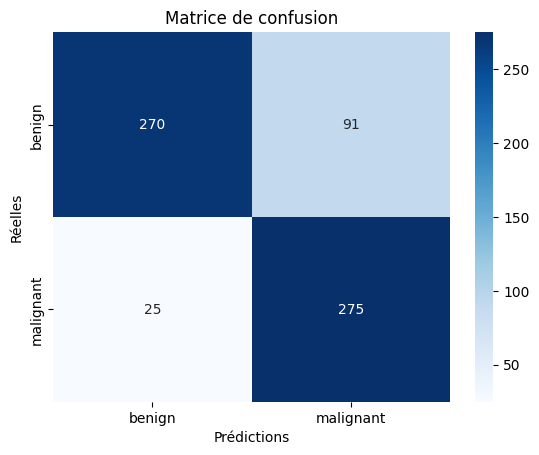

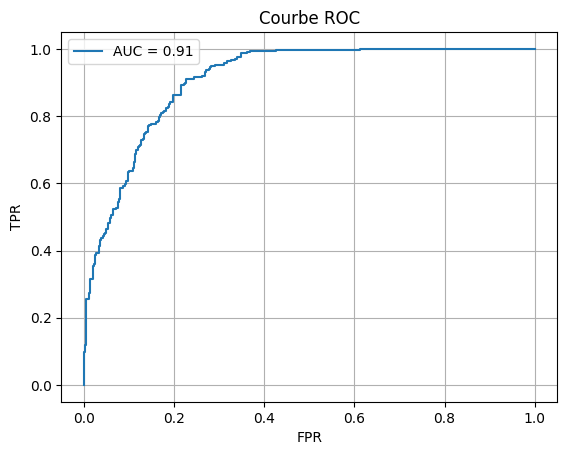

In [9]:
#Étape 6 – Évaluation finale + matrice de confusion + courbe ROC

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np

# Test
model.eval()
test_preds, test_labels, probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        prob = torch.softmax(outputs, dim=1)[:, 1]
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        probs.extend(prob.cpu().numpy())

# Matrice de confusion
def plot_confusion_matrix(true, pred, classes):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédictions")
    plt.ylabel("Réelles")
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix(test_labels, test_preds, classes)

# ROC
fpr, tpr, _ = roc_curve(test_labels, probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(test_labels, probs):.2f}")
plt.title("Courbe ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
def evaluate_model(model, loader, classes, epoch=None, total_epochs=None):
    model.eval()
    all_preds = []
    all_labels = []

    if epoch is not None and total_epochs is not None:
        print(f"\n🧪 Évaluation à l’époque {epoch + 1}/{total_epochs}")

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if len(all_preds) == 0:
        print("⚠️ Aucun échantillon trouvé dans le DataLoader.")
        return

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    print(f"✅ Accuracy : {acc:.4f}")
    print(f"🎯 F1 Score : {f1:.4f}")
    print("\n📋 Rapport de classification :")
    print(classification_report(all_labels, all_preds, target_names=classes))


In [15]:
# Sauvegarder uniquement les poids du modèle
torch.save(model.state_dict(), "simple_cnn.pth")
print("✅ Modèle sauvegardé dans simple_cnn.pth")


✅ Modèle sauvegardé dans simple_cnn.pth


In [17]:
from model import SimpleCNN  # classe identique à celle du notebook

# Recréation de l'architecture
model = SimpleCNN()

# Chargement des poids
model.load_state_dict(torch.load("simple_cnn.pth"))

# Mettre le modèle en mode évaluation
model.eval()

print("✅ Modèle rechargé et prêt à être utilisé")


✅ Modèle rechargé et prêt à être utilisé
